Please upload a binary (black & white) image...


Saving download.jpg to download.jpg


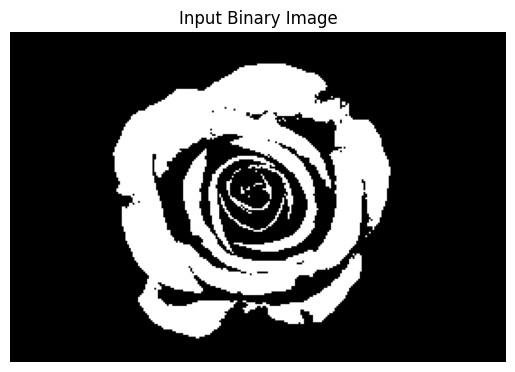

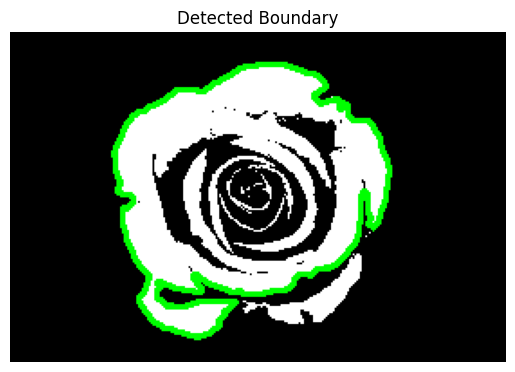

===== SIMPLE BOUNDARY DESCRIPTORS =====
Perimeter: 737.65
Area: 15285.50
Centroid: (129, 86)
Aspect Ratio: 1.013
Eccentricity: 0.553
Compactness: 2.833

===== CHAIN CODE (first 50 values) =====
[5, 4, 4, 4, 4, 4, 4, 5, 4, 4, 5, 5, 4, 5, 5, 4, 5, 4, 5, 4, 5, 5, 4, 4, 5, 5, 5, 4, 5, 5, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 4, 5] ...


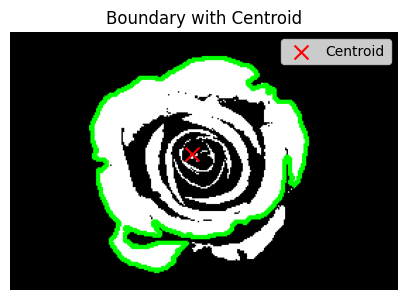

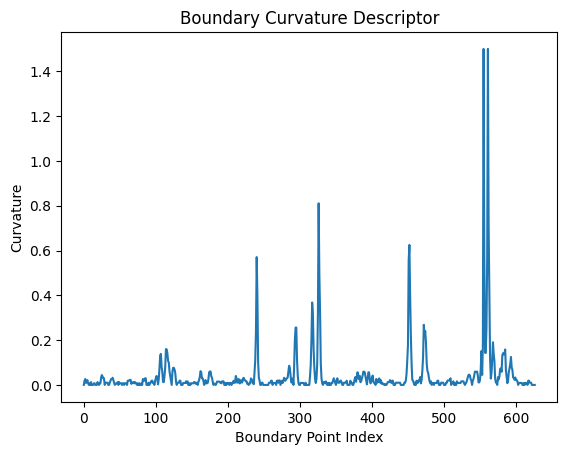

In [3]:
# =============================================
# BOUNDARY DESCRIPTORS IMPLEMENTATION (Google Colab)
# =============================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from google.colab import files

# -----------------------------
# 1. Upload Binary Image
# -----------------------------
print("Please upload a binary (black & white) image...")
uploaded = files.upload()

for fn in uploaded.keys():
    image_path = fn

# Read and threshold the image
img = cv2.imread(image_path, 0)
_, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)

plt.imshow(img, cmap='gray')
plt.title("Input Binary Image")
plt.axis('off')
plt.show()

# -----------------------------
# 2. Extract Boundary (Contour)
# -----------------------------
contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
if len(contours) == 0:
    raise ValueError("No contours found in the image. Make sure it's a binary shape.")

boundary = max(contours, key=cv2.contourArea)  # choose the largest contour

# Draw the boundary
boundary_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(boundary_img, [boundary], -1, (0, 255, 0), 2)

plt.imshow(boundary_img)
plt.title("Detected Boundary")
plt.axis('off')
plt.show()

# -----------------------------
# 3. Simple Boundary Descriptors
# -----------------------------
perimeter = cv2.arcLength(boundary, True)
area = cv2.contourArea(boundary)
M = cv2.moments(boundary)

if M['m00'] != 0:
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
else:
    cx, cy = 0, 0

x, y, w, h = cv2.boundingRect(boundary)
aspect_ratio = float(w) / h

# Eccentricity via ellipse fitting (fixed unpacking)
eccentricity = 0
if len(boundary) >= 5:  # fitEllipse requires at least 5 points
    (x0, y0), (MA, ma), angle = cv2.fitEllipse(boundary)
    a = max(MA, ma) / 2
    b = min(MA, ma) / 2
    eccentricity = sqrt(1 - (b / a) ** 2)

compactness = (perimeter**2) / (4 * np.pi * area)

print("===== SIMPLE BOUNDARY DESCRIPTORS =====")
print(f"Perimeter: {perimeter:.2f}")
print(f"Area: {area:.2f}")
print(f"Centroid: ({cx}, {cy})")
print(f"Aspect Ratio: {aspect_ratio:.3f}")
print(f"Eccentricity: {eccentricity:.3f}")
print(f"Compactness: {compactness:.3f}")

# -----------------------------
# 4. Freeman Chain Code (8-connectivity)
# -----------------------------
def chain_code(contour):
    chain = []
    for i in range(len(contour) - 1):
        x1, y1 = contour[i][0]
        x2, y2 = contour[i + 1][0]
        dx, dy = x2 - x1, y2 - y1

        if dx == 1 and dy == 0: direction = 0
        elif dx == 1 and dy == -1: direction = 1
        elif dx == 0 and dy == -1: direction = 2
        elif dx == -1 and dy == -1: direction = 3
        elif dx == -1 and dy == 0: direction = 4
        elif dx == -1 and dy == 1: direction = 5
        elif dx == 0 and dy == 1: direction = 6
        elif dx == 1 and dy == 1: direction = 7
        else: direction = -1
        chain.append(direction)
    return [c for c in chain if c != -1]

chain = chain_code(boundary)

print("\n===== CHAIN CODE (first 50 values) =====")
print(chain[:50], "...")

# -----------------------------
# 5. Visualize Centroid
# -----------------------------
plt.figure(figsize=(5, 5))
plt.imshow(boundary_img)
plt.scatter(cx, cy, color='red', marker='x', s=100, label='Centroid')
plt.legend()
plt.title("Boundary with Centroid")
plt.axis('off')
plt.show()

# -----------------------------
# 6. Curvature Descriptor
# -----------------------------
def curvature(contour, step=5):
    curv = []
    for i in range(step, len(contour)-step):
        p_prev = contour[i - step][0]
        p_next = contour[i + step][0]
        p_curr = contour[i][0]

        dx = p_next[0] - p_prev[0]
        dy = p_next[1] - p_prev[1]
        ddx = p_next[0] - 2*p_curr[0] + p_prev[0]
        ddy = p_next[1] - 2*p_curr[1] + p_prev[1]

        num = abs(dx * ddy - dy * ddx)
        denom = (dx**2 + dy**2)**1.5 + 1e-6
        curv.append(num / denom)
    return np.array(curv)

curv_values = curvature(boundary)
plt.plot(curv_values)
plt.title("Boundary Curvature Descriptor")
plt.xlabel("Boundary Point Index")
plt.ylabel("Curvature")
plt.show()
